# Lecture 35: Cellular Automata in Python

```{note}
This lectures focuses on implementation of Safety Distance Model through Cellular Automata for a single-lane car following model in Python.
```

---

## Nagel–Schreckenberg Model

### Introduction

The NaSch Cellular Automaton (short for Nagel–Schreckenberg model) is one of the most widely used cellular automata models to study vehicular traffic flow. Here, space is discretized into cells (1D Lattice) wherein each cell is either empty or occupied by exactly one vehicle, while time progresses in discrete steps, rendering discrete vehicle speeds. It was proposed in 1992 by Kai Nagel and Michael Schreckenberg as a microscopic, stochastic traffic model, designed to capture essential dynamics of highway traffic while being simple enough for large-scale simulation.

**Attributes**

- Location: $x_i(t)$

- Speed: $v_i(t)$

**Behavioral Rules**

- Acceleration: $v_i(t + \Delta t) \rightarrow \min (v_i(t) + 1, \bar{v})$

- Deceleration: $v_i(t + \Delta t) \rightarrow \min (v_i(t), h_i(t))$

- Stochastic Braking: $v_i(t + \Delta t) \rightarrow \max (v_i(t) - 1, 0)$ with probability $p$

- Movement: $x_i(t + \Delta t) \rightarrow x_i(t) + v_i(t + \Delta t)$

**Simulation Mechanism**

- Initialization: Define road length $l$, maximum velocity $\bar{v}$, braking probability $p$, and number of vehicle $n$. Randomly assign vehicle positions $x_i(0)$ and initial speed $v_i(0) \in [0, \bar{v}]$.

- Perception: Each vehicle observes its immediate leader, computes its headway $h_i(t)$, and notes its current speed $v_i(t)$

- Decision-Making: Accelerate if possible; Decelerate to maintain safe distance; Randomization (stochastic braking)

- Action: Update each vehicle's position

- Environment Update: Resolve the new lattice configuration (occupied and empty cells), ensuring synchronous updates for all vehicles.

- Iteration: Repeat steps for each time step until the simulation horizon $k$ is reached. Collect metrics (flow, density, average speed, jam length).

**Emergent Behavior**

- Free Flow: At low densities, car move at a speed close to $v_{max}$

- Traffic Jams: At higher densities, jams form spontaneously due to the randomization rule

- Phase Transition: The model shows a transition from free flow to congested traffic as density increases

- Stop-and-Go Waves: Jam fronts propagate backward through traffic, resembling real highway observations.

---

### Implementation

#### Pseudo Code
$$
\begin{aligned}
1.\ & \textbf{Procedure } \text{NaSchCA}(l, n, v, p, k) \\
2.\ & s \leftarrow \left\lfloor \tfrac{l}{n} \right\rfloor \quad \text{// lattice spacing for uniform placement} \\
3.\ & X \leftarrow \{0, s, 2s, \dots, s(n-1)\} \bmod l \quad \text{// initial vehicle positions (ring)} \\
4.\ & V \leftarrow \{0;\ i=1,\dots,n\} \quad \text{// initial speeds} \\
5.\ & I \leftarrow \{1,\dots,n, 0\} \quad \text{// leader index (periodic)} \\
6.\ & f \leftarrow 0 \quad \text{// mean flow accumulator} \\
7.\ & Z \leftarrow \text{matrix}_{k \times l}(-1) \quad \text{// space--time raster ($-1 =$ empty)} \\
8.\ & \textbf{for } t = 0 \ \textbf{to } k-1 \ \textbf{do} \\
9.\ & \quad Z[t, X] \leftarrow V \quad \text{// record current occupancy/speeds} \\
10.\ & \quad H \leftarrow (X[I] - X - 1) \bmod l \quad \text{// gaps: empty cells ahead} \\
11.\ & \quad V \leftarrow \min(V+1,\ v) \quad \text{// Acceleration} \\
12.\ & \quad V \leftarrow \min(V,\ H) \quad \text{// Deceleration (safety distance)} \\
13.\ & \quad r \leftarrow \text{rng.uniform}(0,1)^n \quad \text{// i.i.d. uniforms} \\
14.\ & \quad M \leftarrow (r < p)\ \wedge\ (V > 0) \quad \text{// stochastic braking mask} \\
15.\ & \quad V[M] \leftarrow V[M] - 1 \quad \text{// Randomization} \\
16.\ & \quad X \leftarrow (X + V) \bmod l \quad \text{// Movement} \\
17.\ & \quad f \leftarrow f + \dfrac{\sum_i V_i}{k \cdot l} \quad \text{// accumulate normalized flow} \\
18.\ & \textbf{end for} \\
19.\ & \textbf{return } \{X, V, Z, f\} \quad \text{// final state, raster, mean flow}
\end{aligned}
$$


#### Python Implementation

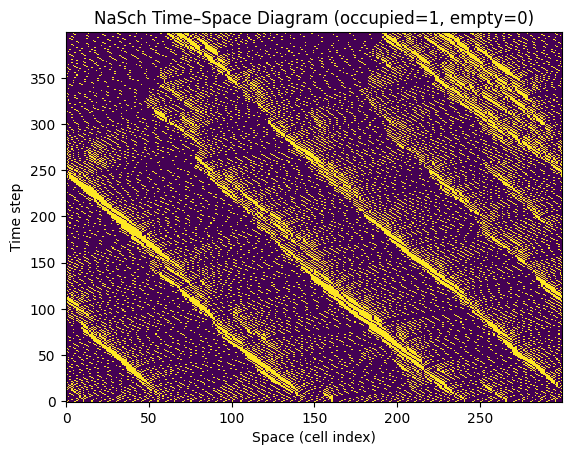

In [4]:
# Time–space occupancy diagram
import matplotlib.pyplot as plt

# Input Parameters
l = 300
n = 60
v = 10
p = 0.2
k = 400
seed = 0

# Output
R = NaSchCA(l, n, v, p, k, seed)
Z = (R["Z"] >= 0).astype(int)

# Plot
plt.figure()
plt.imshow(Z, aspect='auto', origin='lower', interpolation='nearest')
plt.xlabel("Space (cell index)")
plt.ylabel("Time step")
plt.title("NaSch Time–Space Diagram (occupied=1, empty=0)")
plt.show()

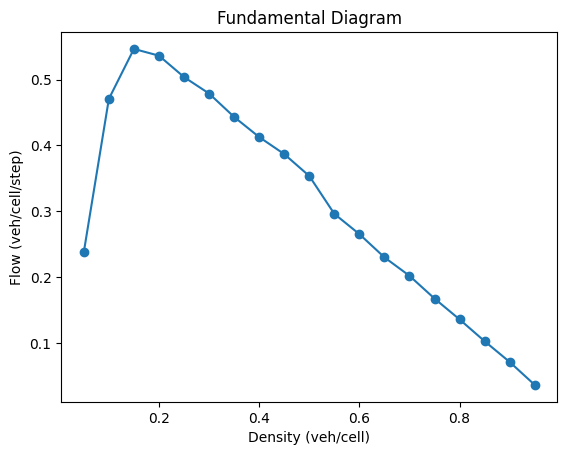

In [ ]:
# Fundamental diagram (flow vs density) via density sweep
import numpy as np
import matplotlib.pyplot as plt

# Input Parameters
l = 300
n = 2
v = 5
p = 0.2
k1 = 300
k2 = 600
seed = 0

D = np.linspace(0.05, 0.95, 19)
F = []

for d in D:
    n = max(1, int(round(d*l)))
    _ = NaSchCA(l, n, v, p, k1, seed)
    R = NaSchCA(l, n, v, p, k2, seed)
    F.append(R["f"])

plt.figure()
plt.plot(D, F, marker='o')
plt.xlabel("Density (veh/cell)")
plt.ylabel("Flow (veh/cell/step)")
plt.title("Fundamental Diagram")
plt.show()